<a href="https://colab.research.google.com/github/royam0820/DL/blob/master/copy_of_v3_1_lesson3_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB

Last example before we look at more foundational theory stuff, NLP (Natural Language Processing). Next week, we're going to be looking at a lot more NLP, but let's now do the same thing but rather than creating a classification of pictures, **let's try and classify documents**. We're going to go through this in a lot more detail next week, but let's do the quick version.

## Lesson  Notes

[from hiromis](https://github.com/hiromis/notes/blob/master/Lesson3.md)

[from poonav](https://forums.fast.ai/t/deep-learning-lesson-3-notes)

[discussion thread](https://forums.fast.ai/t/lesson-3-discussion)

[video timeline](https://forums.fast.ai/t/lesson-3-official-resources-and-updates/29732)

[imdb video timing - Lesson 3](https://www.youtube.com/watch?v=PW2HKkzdkKY&feature=youtu.be&t=6067)

[imdb video timing - lesson 4](https://www.youtube.com/watch?v=C9UdVPE3ynA&feature=youtu.be&t=3m43s)

[fasai-doc](https://docs.fast.ai/)


## Natural Language Processing (NLP)
Natural language is about reading, writing, and speaking. NLP goal is for computers to “understand” natural language in order to perform a task. Lot's of digital assistants are doing that: Alexa, Siri, Cortana ...

In this lesson we will use **text classification**.

Classifying text or document can be used for anything from spam prevention to identifying fake news to finding a diagnosis to medical reports, finding mentions of your product on twitter, classifying legal documents ... etc.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

NOTE: Rather than importing from fastai.vision, I now import, for the first time, from fastai.text. That's where you'll find all the application specific stuff for analyzing text documents.

In this case, we're going to use a dataset called IMDB. IMDB has lots of movie reviews. They're generally about a couple of thousand words, and each movie review has been classified as either negative or positive.

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [0]:
#!rmdir data

rmdir: failed to remove 'data': Directory not empty


In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
!path(ls)

/bin/bash: -c: line 0: syntax error near unexpected token `ls'
/bin/bash: -c: line 0: `path(ls)'


It only contains one csv file, let's have a look at it.

NOTE:  It's just in a CSV file, so we can use pandas to read it and we can take a little look.

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


NOTE:  column `is_valid` boolean variable to indicate if it is in a validation set or training set.

In [0]:
# example of a movie review
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
# a quick way to create a text databuch from the csv file: texts.csv
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: **tokenization** and **numericalization**. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [0]:
data_lm.save()

You can save the data bunch which means that the pre-processing that is done, you don't have to do it again. You can just load it.
Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [0]:
data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly **tokens**.  Each token represents a single linguistic concept.The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [0]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject ,",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk , """,positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk xxunk experience in general . xxmaj with graphics",positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used.
NB:  every word in a vocab requires a separate row in our weight metrics.  So to avoid that weight metrics to be really huge, **we only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.**

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (**for int to string**).

In [0]:
# the first 10 tokens in order of frequency
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

First 10 items of the vocab. And if we look at what a what's in our datasets, we'll see the tokenized text as a representation. `xxunk` = unknown word, `xxfld` = special fields in the structure of a document such as title, summary ...

NOTE:  So here is every possible token (the first ten of them) that appear in our all of the movie reviews. We then replace every movie review with a list of numbers.

In [0]:
data.train_ds[0][0]

Text xxbos and laugh out loud funny in many scenes . 

 xxmaj the movie 's basic plot is well xxunk , a story of xxunk trying to find a way to survive each other in close xxunk . 

 xxmaj this is xxunk xxmaj xxunk and xxmaj xxunk 's best film as co - stars , and the xxunk between the sloppy xxmaj oscar and the xxup xxunk xxmaj felix are classic . 

 xxmaj the scene where xxmaj oscar lines up a double date , leaves the room briefly , and comes back to find xxmaj felix and the two girls all crying is xxunk funny . 

 xxmaj for any fan of intelligent comedies , xxmaj the xxmaj odd xxmaj couple is a " go out of your way to see it " film .

But the underlying data is all numbers

In [0]:
# we replace the tokens with the ID of where is that token in the vocab:
data.train_ds[0][0].data[:10]

array([   2,   11,  605,   58, 1248,  184,   17,  133,  154,    9])

NOTE:  The list of numbers simply says what numbered thing in the vocab is in this place.  For example, 2, represents the vocab "xxbos".

So through tokenization and numericalization, this is the standard way in NLP of turning a document into a list of numbers.

We can do that with the data block API:

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.



```
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
           #Where are the inputs? Column 'text' of this csv
                   .random_split_by_pct()
           #How to split it? Randomly with the default 20%
                   .label_for_lm()
           #Label it for a language model
                   .databunch())
```



In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

NOTE:  we indicate :
- the inputs, colum type of 'text' of the csv file
- how to do the split for the validation phase (in this case, column #2 in our csv file is our validation flag)
- Get the labels (negative or positive sentiment, column 0 in our csv file.)
- Convert the file to a databunch.

## Training

**Language model**

We are going to create two models, the first model is called the **language model,** we train it, and after that we create a **classifier model**.  This is a quick version, we will go into more details next week

NOTE:  A **language model** learns to predict what word comes next in a sentence.  And to predict the next word in a sentence you need to know quite a lot about English (assuming it is in English) and quite a lot about word knowledge.

For instance:
1.   I like to eat a hot ??? (dog)
2.   It is a hot ??? (day) 



Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs=48
#bs=64 #out of memory error

Now let's grab the full dataset for what follows.

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/models'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train')]

NOTE:  the IMDB dataset has 25000 movie reviews in the `train` and the `test` folders, and 15000 unsupervised in the `unsup` folder, review that have not been scored at all.

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

In [0]:
(path/'test').ls()

[PosixPath('/root/.fastai/data/imdb/test/pos'),
 PosixPath('/root/.fastai/data/imdb/test/neg'),
 PosixPath('/root/.fastai/data/imdb/test/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

[data block API](https://docs.fast.ai/data_block.html)

In [0]:
# training the IMDB dataset using the untrained data to fine tune our language model
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

NOTE:  The IMDB dataset is a list of text files﹣not a CSV file. Each document is a separate text file.
- We are including the `train`, `test` and `unsup` folders. 
- We randomly split it by 0.1.


We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [0]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"brutal , stylish , and ultimately unique film within the genre . \n\n xxmaj the entire cast is solid , xxmaj gene xxmaj nelson gives a very good performance as ex con xxmaj steve xxmaj lacey and xxmaj charles xxmaj bronson ( credited as xxmaj charles xxmaj buchinsky ) gives a new meaning to the word "" sleazebag "" with his performance as baddie xxmaj ben xxmaj hastings - but"
1,"'s little joke on all of us ? xxmaj this is essentially a film about his own obsessions , or a grand parody on horror , as some suggested . xxmaj von , xxmaj trier , frustrated by the delay of his never realized project , "" xxmaj the xxmaj grand xxmaj mal "" , about two gangster families in divided xxmaj berlin , made a bet with film consultant"
2,"gypsy folktale . xxmaj in the film xxmaj nikki , as "" xxmaj sue , "" is cheating on her husband , and during the shoot xxmaj nikki 's "" real xxunk warns her not to do it for real . xxmaj but of course she does : the film relationship parallels "" real life , "" and the stars find they 're confusing themselves with their film characters ,"
3,"she has numbers tattooed all over her chest , a bunch of crazies wielding rifles arrive in an old truck . xxmaj in the dispute that follows , one of the paramedics is shot in the shoulder and in the end all four are kidnapped by these people . \n\n xxmaj they are taken to some underground facility , where xxunk constantly play some type of speech / mantra ."
4,", while none of this bunch of mercenary hacks would even dream of questioning the xxunk of the xxunk xxunk system we call democracy ! xxmaj so i guess xxmaj ken is right , we need educating ! xxmaj and what better way to do that that to show us how the whole thing works in practice , the smaller wheels , the larger ones , the cogs . xxmaj"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

NOTE: we are using a `language_model_learner` which is a Recurrent Neural Network (RNN), we use a pre-trained model (`WT103_1`) and a drop out feature: `drop_mult = 0.3`.

`drop_mult=0.3` sets the amount of dropout. We haven't talked about that yet. We've talked briefly about this idea that there is something called regularization and you can reduce the regularization to avoid underfitting. So for now, just know that by using a number lower than one is because when I first tried to run this, I was under fitting. So if you reduced that number, then it will avoid under fitting.

NOTE:  This time, it's not ImageFilesList, it's TextList from a CSV and create a data bunch. At that point, we can start to create a model.

As we learn about next week, when we do NLP classification, we actually create two models:  The first model is something called a **language model** which we train in a kind of a usual way.  We say we want to create a language model learner, train it, save it, and we unfreeze, train some more.

After we've created a language model, we fine-tune it to create the ** classifier**. We create the data bunch of the classifier, create a learner, train it and we end up with some accuracy.



In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


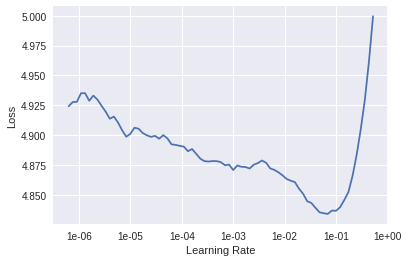

In [0]:
learn.recorder.plot(skip_end=15)

NOTE:  For the learning rate finder you can use  `skip_start` and `skip_end`, they  are there if you want to ‘skip’ some point in the plot (at the beginning or at the end respectively).

This can be useful when you loss goes very very high at the end, sometimes leading to a final graph that is ‘squished’, making it unreadable, that is why in the example above: `skip_end=15` has been used.  Those values are the number of loss values that you won’t plot using this function.

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

NOTE:  What’s happening here is we are just fine-tuning the last layers. Normally after we fine-tune the last layers, the next thing we do is we go unfreeze and train the whole thing. 

In [0]:
learn.save('/content/fit_head')

In [0]:
learn.load('/content/fit_head');

## Fine Tuning

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

NOTE:  As you can see, even on a pretty beefy GPU that takes two or three hours. In fact, I’m still underfitting. So probably tonight, I might train it overnight and try and do a little bit better. I’m guessing I could probably train this a bit longer because you can see the accuracy hasn’t started going down again. So I wouldn’t mind trying to train that a bit longer. But the accuracy, it’s interesting. 0.3 means we’re guessing the next word of the movie review correctly about a third of the time. That sounds like a pretty high number﹣the idea that you can actually guess the next word that often. So it’s a good sign that my language model is doing pretty well. For more limited domain documents (like medical transcripts and legal transcripts), you’ll often find this accuracy gets a lot higher. So sometimes this can be even 50% or more. But 0.3 or more is pretty good.

In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


NOTE :  `learn.predict()` passes in the start of a sentence, and it will try to finish off that sentence for you.

Now I should mention, this is not designed to be a good text generation system. This is really more designed to check that it seems to be creating something that's vaguely sensible. There's a lot lot of tricks that you can use to generate much higher quality text﹣none of which we're using here. But you can kind of see that it's certainly not random words that it's generating. It sounds vaguely English like even though it doesn't make any sense.

At this point, we have a movie review model. So now we're going to save that in order to load it into our classifier (i.e. to be a pre-trained model for the classifier). But I actually don't want to save the whole thing. A lot of the second half of the language model is all about predicting the next word rather than about understanding the sentence so far. So the bit which is specifically about understanding the sentence so far is called the encoder, so I just save that (i.e. the bit that understands the sentence rather than the bit that generates the word).

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

NOTE:  At this point we have a movie review model.
Next, we will build a classifier to classify movie review by positive or negative.

## Classifier - Sentiment Analysis

Now we’re ready to create our classifier. Step one, as per usual, is to create a data bunch, and we’re going to do basically exactly the same thing

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

NOTE:  But we want to make sure that it uses exactly the same vocab that are used for the language model. If word number 10 was "the" in the language model, we need to make sure that word number 10 is the in the classifier. Because otherwise, the pre-trained model is going to be totally meaningless. So that's why we pass in the vocab from the language model to make sure that this data bunch is going to have exactly the same vocab. That's an important step.

`split_by_folder`﹣remember, the last time we had split randomly, but this time we need to make sure that the labels of the test set are not touched. So we split by folder.

And then this time we label it not for a language model but we label these classes ([`neg`, `pos`]). Then finally create a data bunch.

Attn:  **Sometimes you'll find that you ran out of GPU memory**. I was running this in an 11G machine, so you should make sure this number (bs) is a bit lower if you run out of memory. You may also want to make sure you **restart the notebook** 
and  start it just from here (**the classifier section**). Batch size 50 is as high as I could get on an 11G card. If you're using a p2 or p3 on Amazon or the K80 on Google, for example, I think you'll get 16G so you might be able to make this bit higher, get it up to 64. So you can find whatever batch size fits on your card.

So here is our data bunch:

In [0]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxmaj no , this is n't a sequel to the fabulous xxup ova series , but rather a remake of the events that occurred after the death of xxmaj xxunk ( and the disappearance of xxmaj woodchuck ) . xxmaj it is also more accurate to the novels that inspired this wonderful series , which is why characters ( namely xxmaj orson and xxmaj xxunk ) are xxunk ,",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc') # loading our pre-trained model
learn.freeze()

NOTE:  This time, rather than creating a language model learner, we’re creating a text classifier learner. But again, the same thing﹣pass in the data that we want, figure out how much regularization we need.

Dropout - drop_mult
If you’re overfitting then you can increase this number (drop_mult). If you’re underfitting, you can decrease the number. And most importantly, load in our pre-trained model.

Remember, specifically it’s this half of the model called the encoder which is the bit that we want to load in.

Then freeze, lr_find, find the learning rate.

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

Fit for a little bit ...

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.310078,0.197204,0.926960


NOTE:  We’re already up nearly to 92% accuracy after less than three minutes of training. So this is a nice thing. In your particular domain (whether it be law, medicine, journalism, government, or whatever), you probably only need to train your domain’s language model once. And that might take overnight to train well. But once you’ve got it, you can now very quickly create all kinds of different classifiers and models with that. In this case, already a pretty good model after three minutes. So when you first start doing this. you might find it a bit annoying that your first models take four hours or more to create that language model. **But the key thing to remember is you only have to do that once for your entire domain of stuff that you’re interested in. And then you can build lots of different classifiers and other models on top of that in a few minutes.**

In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


NOTE:  `learn.freeze_to(-2)` unfreeze the last 2 layesrs;  don’t unfreeze the whole thing. We’ve just found it really helps with these text classification not to unfreeze the whole thing, but to unfreeze one layer at a time.

In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3) # unfreese the last 2 layers
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


NOTE:  You also see I’m passing in this thing `moms=(0.8,0.7)`﹣momentums equals 0.8,0.7. We are going to learn exactly what that means probably next week. We may even automate it. So maybe by the time you watch the video of this, this won’t even be necessary anymore. Basically, we found for training recurrent neural networks (RNNs), it really helps to decrease the momentum a little bit. So that’s what that is.

That gets us a 94.4% accuracy after about half an hour or less of training. There’s quite a lot less of training the actual classifier. We can actually get this quite a bit better with a few tricks. I don’t know if we’ll learn all the tricks this part. It might be the next part. But even this very simple standard approach is pretty great.

If we compare it to last year’s state of the art on IMDb, this is from The CoVe paper from McCann et al. 1 at Salesforce Research, we were at 94.1%

In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))

NOTE:  That's the really quick version. We're going to go through it in more detail next week, but you can see the basic idea of training and NLP classifier is very similar to creating every other model we've seen so far. The current state of the art for IMDB classification is actually the algorithm that we built and published with colleague named Sebastian Ruder and what I just showed you is pretty much the state of the art algorithm with some minor tweaks. You can get this up to about 95% if you try really hard. So this is very close to the state of the art accuracy that we developed.

## Final Notes
· The layers of the network are linear, connected to each other by Activation functions.

- An activation function takes the matrix multiplication and sticks it through some function.  [Sagar Sharma - Activation Functions](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6). In the old days, the activation funtion most used was a sigmoid function, today we nearly always use the ReLu function (rectified linear unit), a sophiticated name to indicate that negative numbers will be equal to 0, the function is in fact: `max(x,0)`.
-  If activation functions are linear too, the whole network will be linear.
- Introducing non-linear activation function introduces non-linearity in the network.
- Universal Approximation Theorem:  means that any shape can be approximated by a combination of linear layers and non linear activation functions.
-  Earlier sigmoid was the most used activation function. Currently, ReLU(Rectified Linear Unit) or leaky-ReLU is generally used.

[Ref.: Neural networks & Deep Learning](http://neuralnetworksanddeeplearning.com/)

# Assignments

Try to come up with an interesting idea of a problem you would like to solve which is either:
- multi-label classification
- image segmentation
- image regression

By working on this homework, you will find out that the hardest part  to solve the problem is regarding the creation of the databuch.  For that, do check the [data block API](https://docs.fast.ai/data_block.html) and make sure to use the mos appropriate data buch that best fit the data you will be handling.